# Segmentation

## U-Net Approach

### Ressources

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

### Goal

Train a network to segment out potentially cancerous nodules and the use the characteristiccs of that segmentation to make predictions about the diagnosis of the scanned patient within 12 month time frame.

Images are scans from low-dose helical computed tomography(CT). The Lung Nodule Analysis 2016 (LUNA2016) challenge has made CT images with annotated nodule locations available [here](https://luna16.grand-challenge.org/).

### Data (LUNA16)

In [1]:
luna_data = '/home/mark/data/datasets/cv/luna16/'

In [138]:
%matplotlib inline
import importlib
import utils; importlib.reload(utils)
from utils import make_mask, isolate_lungs
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
file_list = glob(luna_data+'**/*.mhd'); len(file_list)

888

Helper function to get rows in DataFrame associated with each .mhd file

In [6]:
def get_fname(case):
    for f in file_list:
        if case in f: return (f)

Locations of the nodes

In [10]:
df_node = pd.read_csv(luna_data+'CSVFILES/annotations.csv'); df_node.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [13]:
df_node['file'] = df_node['seriesuid'].apply(get_fname).dropna(); df_node.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,file
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,/home/mark/data/datasets/cv/luna16/subset8/1.3...
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708,/home/mark/data/datasets/cv/luna16/subset8/1.3...
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,/home/mark/data/datasets/cv/luna16/subset5/1.3...
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,/home/mark/data/datasets/cv/luna16/subset2/1.3...
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,/home/mark/data/datasets/cv/luna16/subset2/1.3...


#### Create nodule masks

Get nodule position in the .mhd files, create a mask and save to disk

In [26]:
for fcount, img_file in enumerate(tqdm(file_list)):
    nod_df = df_node[df_node['file']==img_file] # get all nodules associated w/ file
    if len(nod_df) > 0: # skip files with no nodules
        itk_img = sitk.ReadImage(img_file)
        img_array = sitk.GetArrayFromImage(itk_img) # dim-order(z,y,x)
        channels, height, width = img_array.shape
        origin = np.array(itk_img.GetOrigin()) # x,y,z (mm)
        spacing = np.array(itk_img.GetSpacing()) # spacing of voxels
        for node_idx, row in nod_df.iterrows():
            x = row['coordX']
            y = row['coordY']
            z = row['coordZ']
            diam = row['diameter_mm']
            # limit to 3 channels
            imgs = np.ndarray([3, height, width], dtype=np.float32)
            masks = np.ndarray([3, height, width], dtype=np.uint8)
            center = np.array([x, y, z]) # nodule center
            v_center = np.rint((center-origin)/spacing) # nodule center in voxel space (x,y,z)
            for i, i_z in enumerate(np.arange(int(v_center[2])-1,
                                              int(v_center[2])+2).clip(0, channels-1)):
                mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                                 width, height, spacing, origin)
                masks[i] = mask
                imgs[i] = img_array[i_z]
            np.save(f'./data/images_{fcount}_{node_idx}.npy', imgs)
            np.save(f'./data/masks_{fcount}_{node_idx}.npy', masks)

100%|██████████| 888/888 [12:19<00:00,  1.54it/s]


Visualize images and masks

image 0


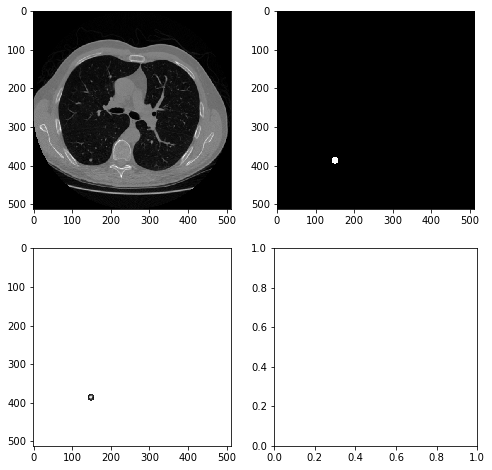

image 1


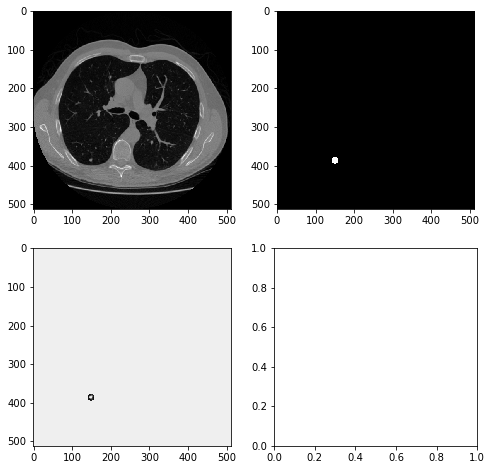

image 2


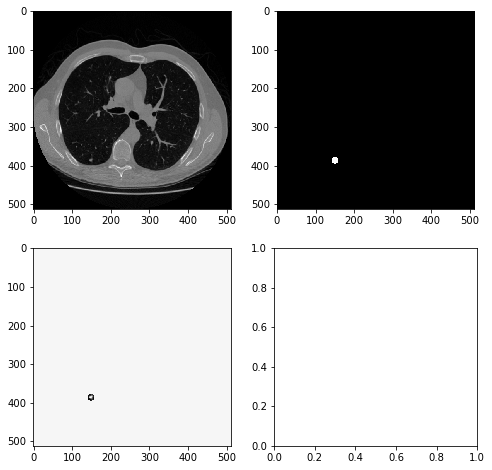

In [21]:
images = np.load('./data/images_101_535.npy')
masks = np.load('./data/masks_101_535.npy')
for i in range(len(images)):
    print(f'image {i}')
    fig, ax = plt.subplots(2, 2, figsize=[8,8])
    ax[0,0].imshow(images[i], cmap='gray')
    ax[0,1].imshow(masks[i], cmap='gray')
    ax[1,0].imshow(images[i]*masks[i], cmap='gray')
    plt.show()

The node masks seems to be constructued properly.

* (0,0): Scan slice
* (0,1): Node mask
* (1,0): Masked scan slice, highlighting the node

#### Isolate Lung Regions

** Strategy: **
* Threshold the image to isolate the regions within the images
* Then identify which of those regions are the lungs
    * The lungs has a high contrast with surrounding tissue


In [39]:
from skimage import morphology, measure
from skimage.transform import resize
from sklearn.cluster import KMeans

In [103]:
img = np.load('./data/images_101_535.npy').astype(np.float64)[0]

##### Standardize pixel values
First step is to standardize the pixels values and take a look at the intensity distribution

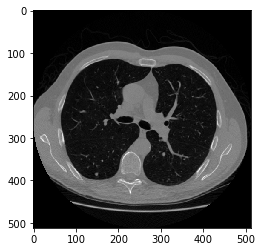

In [104]:
plt.imshow(img, cmap='gray')

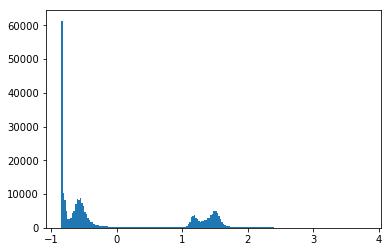

In [105]:
mean = np.mean(img)
std = np.std(img)
img = img-mean
img = img/std
hist = plt.hist(img.flatten(), bins=200)

The images in the dataset vary quite a bit. For this particular image, the peak around -0.8 are the background and lung interior (black). The wide distributions from -0.7 to 2.5 are the non-lung-tissue and bone.

##### Thresholding scans
All images are of size 500x500 with the actual tissue-scan centered (app. 100px margin). The threshold should be between the lung pixel values and the denser tissue pixel values. 

In [106]:
middle = img[100:400, 100:400]
mean = np.mean(middle)
maxv = np.max(img)
minv = np.min(img)
img[img==maxv]=mean
img[img==minv]=mean
kmeans = KMeans(n_clusters=2).fit(np.reshape(middle, [np.prod(middle.shape), 1]))
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)
thresh_img = np.where(img < threshold,1.0,0.0)

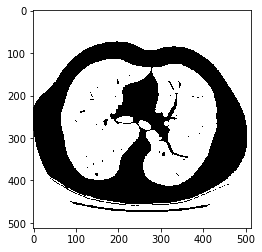

In [112]:
plt.imshow(thresh_img, cmap='gray')

A simple KMeans with 2 clusters seems to separate the scans nicely into 2 distinct regions.

##### Erosion and Dilation
* Use erosion and dilation to fill in the incursions into the lungs region by radio-opaque tissue
* select regions based on bounding box sizes of each region

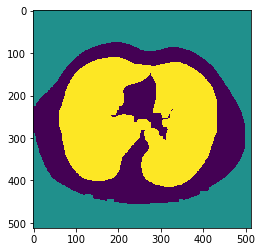

In [114]:
eroded = morphology.erosion(thresh_img, np.ones([4, 4]))
dilation = morphology.dilation(eroded, np.ones([10, 10]))
labels = measure.label(dilation)
label_vals = np.unique(labels)
plt.imshow(labels)

##### Cut non-ROIs
Remove all regions except for the lungs

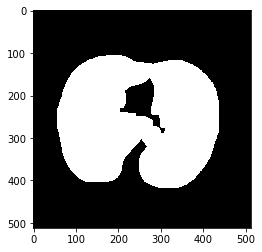

In [124]:
regions = measure.regionprops(labels)
good_labels = []
for prop in regions:
    B = prop.bbox
    if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
        good_labels.append(prop.label)

mask = np.ndarray([512, 512], dtype=np.int8)
mask[:] = 0
for N in good_labels:
    mask = mask + np.where(labels==N, 1, 0)
mask = morphology.dilation(mask, np.ones([10, 10]))
plt.imshow(mask, cmap='gray')

Do above for all the images

In [139]:
images_files = glob('./data/'+'images_*.npy'); len(images_files)

1186

In [141]:
for _, image_file in enumerate(tqdm(images_files)):
    isolate_lungs(image_file)

100%|██████████| 1186/1186 [09:19<00:00,  2.12it/s]
